## Problem 2: Calculate and visualise the *dominance areas* of shopping centres (10 points)

In this problem, the aim is to delineate the dominance area of each shopping centre. For this 
exercise, we define the ‘dominance area’ of a shopping centre as the area from which it can 
be reached faster than other shopping centres. We will use public transport travel times.

![](images/dominance_areas_example_1000x500px.png)

*Sample result: a map showing the areas of dominance of each shopping centre, and the travel 
times to the closest shopping centre in the entire metropolitan area*



---

### Data

The **input data** is identical to what you have used for *problem 1*, 
see [there](./Exercise-4-problem-1.ipynb) for detailed data descriptions.

---


### An overview of the tasks

This task comprises of three major subtasks. In contrast to earlier exercises, we 
do not provide a detailed, step-by-step ‘cooking recipe’. Rather, you are free to
implement the necessary steps in any order you see fit, and choose any variable
names of your liking. 

To test intermediate results, implement `assert` statements, output the `head()`
of a data frame, or plot the data. Remember to add comments to all of your code,
so future you (and us) can understand what each section does.

The **only strict requirement** is the **file name** of
the **output** map plot: `DATA_DIRECTORY / "dominance_areas.png"`.

1. Load the YKR grid and the individual travel time data sets, and combine them 
   into one geo data frame. This is essentially the same as *problem 1*, except
   that you must load all eight shopping centre data files.
2. Find the closest shopping centre to each grid cell. In the combined data set,
   find the minimum travel time to any of the shopping centres, save the value in
   a new column, and shopping centre name in another new column.
   See the [hints](https://autogis-site.readthedocs.io/en/latest/lessons/lesson-4/exercise-4.html#hints)
   to this exercise for a suggestions on how to achieve this 
   ([`pandas.DataFrame.min()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.min.html) and
   [`pandas.DataFrame.idxmin()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.idxmin.html)
   will be helpful)
3. Visualise the dominance areas and travel times. Use 2⨉1 subplots to plot
   the most dominant (closest) shopping centre for each grid cell, and the
   travel time to the closest shopping centre for each grid cell.

---


In [1]:
import pathlib 
NOTEBOOK_PATH = pathlib.Path().resolve()
DATA_DIRECTORY = NOTEBOOK_PATH / "data"

In [2]:
# ADD YOUR OWN CODE HERE
# Imports
import geopandas as gpd
import pandas as pd
import numpy as np
import mapclassify
import matplotlib.pyplot as plt
import glob

/tmp/ipykernel_15408/1794029931.py:3: DeprecationWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas still uses PyGEOS by default. However, starting with version 0.14, the default will switch to Shapely. To force to use Shapely 2.0 now, you can either uninstall PyGEOS or set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In the next release, GeoPandas will switch to using Shapely by default, even if PyGEOS is installed. If you only have PyGEOS installed to get speed-ups, this switch should be smooth. However, if you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gpd


In [3]:
# Read grid
grid = gpd.read_file(DATA_DIRECTORY/"YKR_grid_EPSG3067.gpkg")

# Read csv files
# Get filenames
txt_files = glob.glob(DATA_DIRECTORY.as_posix() + "/" + "*.txt")

# Create a dictionary of df's for each filename
dfs = {}

for file in txt_files:
    # Read the .txt file into a DataFrame
    df = pd.read_csv(file, sep=";")
    df = df[['from_id', 'pt_r_t']]
    df["pt_r_t"] = df["pt_r_t"].replace(-1, np.nan)
    df.dropna(inplace=True)
    df.reset_index(inplace=True, drop=True)
    file_name = file.split("/")[-1].split("_")[-1][:-4]
    df.rename(inplace=True, columns={"pt_r_t":f"pt_r_t_{file_name}"})
    grid = grid.set_index("YKR_ID").join(df.set_index("from_id"), rsuffix=f"_{file_name}").reset_index()

grid.dropna(inplace=True)
grid.reset_index(inplace=True, drop=True)

In [4]:
# ADD YOUR OWN CODE HERE
# Generate cols for inputing data for "closest distances from grid cell to shopping center" and "name of shopping center"
grid["min_pt_r_t"] = 0
grid["Shopping_Center"] = 0

# Calculate the minium value within each row for relevant columns (the ones with distance to shopping center) and apply it to the "min_pt_r_t" column
grid["min_pt_r_t"] = grid.iloc[:, :-2].iloc[:, -7:].min(axis=1)

# Identify the name of the column with the minimum value calculated above and apply it to the "Shopping_Center" column
grid["Shopping_Center"] = grid.iloc[:, :-2].iloc[:, -7:].idxmin(axis=1)

# Clean the naming of these entries in order to only disply the name of the shopping center
grid["Shopping_Center"] = grid["Shopping_Center"].apply(lambda x: x[7:])

grid.drop(columns="geometry").head()

,YKR_ID,pt_r_t_Jumbo,pt_r_t_Omena,pt_r_t_Ruoholahti,pt_r_t_Myyrmanni,pt_r_t_Dixi,pt_r_t_Itis,pt_r_t_Forum,min_pt_r_t,Shopping_Center
0,5785640,101.0,141.0,118.0,90.0,102.0,132.0,110.0,90.0,Myyrmanni
1,5785641,108.0,143.0,121.0,93.0,109.0,135.0,113.0,93.0,Myyrmanni
2,5785642,109.0,145.0,123.0,95.0,111.0,137.0,115.0,95.0,Myyrmanni
3,5785643,114.0,149.0,127.0,99.0,115.0,141.0,119.0,99.0,Myyrmanni
4,5787544,98.0,134.0,111.0,83.0,99.0,125.0,103.0,83.0,Myyrmanni


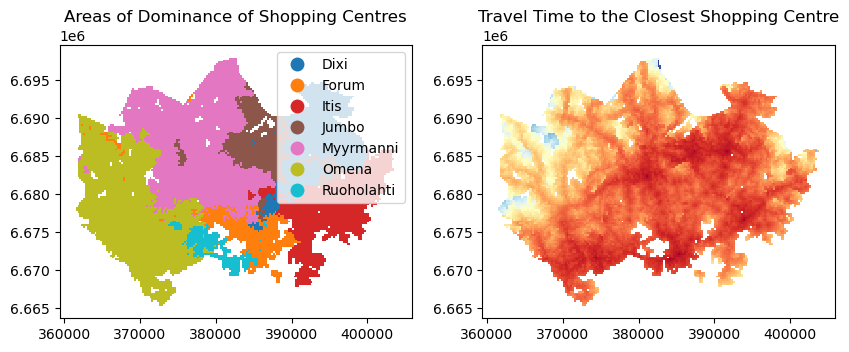

In [8]:
# Generating axes and figure for displaying the map
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 10))
ax11, ax12 = axs[0], axs[1]
axes = [ax11, ax12]

# setting different title, cmap and legend display types for each column name
cl_columns = ["Shopping_Center", "min_pt_r_t"]
titles = ["Areas of Dominance of Shopping Centres", "Travel Time to the Closest Shopping Centre"]
cmaps = [None, "RdYlBu"]
legends = [True, False]

# Plotting data, 
for col, ax, title, cmap, legend in zip(cl_columns, axes, titles, cmaps, legends):
    ax.set_title(title)
    grid.plot(ax=ax, column=col, cmap=cmap, legend=legend, linewidth=0)

# Saving image
fig.savefig(DATA_DIRECTORY/'dominance_areas.png')

In [6]:
# NON-EDITABLE TEST CELL
# Check that output figure file exists
assert (DATA_DIRECTORY / "dominance_areas.png").exists()


--- 

**Do not forget to plot the result map, and save it to `DATA_DIRECTORY / "dominance_areas.png"`!**

---

## Reflections

This was a significantly more complex exercise that previous ones, and it included finding
a solution yourself. 

- What was most difficult part? 
- Where did you get stuck? 
- What was the easiest, and
- what was the most fun part of this exercise?

Add your answer below


---

## Well done!

Congratulations, you completed exercise 4. Good Job!